In [3]:
import os, sys
import pandas as pd
import numpy as np
import sklearn
#import pycs

In [4]:
#load the data
datapath = "data/training_set.csv"
metadata = "data/training_set_metadata.csv"

df = pd.read_csv(datapath)
print("data:\n", df.tail())

dfm = pd.read_csv(metadata)
print("\n\nmetadata:\n", dfm.tail())

# define some equivalencies to ease the visualisation
nicebands = {0: "u", 1: "g", 2: "r", 3: "i", 4: "z", 5: "y"}

data:
          object_id         mjd  passband       flux   flux_err  detected
1421700  130779836  60555.9838         4 -39.881969  46.477093         0
1421701  130779836  60560.0459         1  14.894439  18.947685         0
1421702  130779836  60571.0225         5  30.593130  50.695290         0
1421703  130779836  60585.9974         4 -23.471439  44.819859         0
1421704  130779836  60588.0372         0 -41.214264  51.665123         0


metadata:
       object_id          ra       decl       gal_l      gal_b  ddf  \
7843  130739978   26.718750 -14.940303  172.342697 -72.255675    0   
7844  130755807  120.101349 -62.696659  275.742955 -16.509746    0   
7845  130762946  203.108109 -55.682144  308.728904   6.727511    0   
7846  130772921   79.101562 -35.501846  239.172243 -33.827844    0   
7847  130779836  301.992188 -17.426323   25.102988 -24.511101    0   

      hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  \
7843         0.0000          0.0000           

In [6]:
# how many objects do we have here?
objs_ids = list(set(df["object_id"]))
print("differents objects: ", len(objs_ids))

# and how many classes (targets?)
targets = list(set(dfm["target"]))
print("different targets: ", len(targets))

# what is the targets repartition
import matplotlib.pyplot as plt

unique, counts = np.unique(dfm["target"], return_counts=True)
target_counts = dict(zip(unique, counts))


print(target_counts)
sys.exit()

target_counts_list = sorted(target_counts.iteritems(), key=lambda t: t[1])

plt.figure(figsize=(10, 8))
ax = plt.subplot(111)
xticklabels = []
for ind, (target, count) in enumerate(target_counts_list):
	ax.fill_between(x=(ind-0.5, ind+0.5), y1=0, y2=count)
	xticklabels.append(target)
ax.set_xticks(np.arange(len(target_counts_list)))	
ax.set_xticklabels(xticklabels)
ax.set_xlabel("Target identifier", fontsize=14)
ax.set_ylabel("# of occurences", fontsize=14)
plt.show()

differents objects:  7848
different targets:  14
{6: 151, 15: 495, 16: 924, 42: 1193, 52: 183, 53: 30, 62: 484, 64: 102, 65: 981, 67: 208, 88: 370, 90: 2313, 92: 239, 95: 175}


SystemExit: 

/home/vivien/Programs/miniconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2870: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# Now, let's look at the curves. We pick randomly one per class

import random

#TODO: f0 and b normalization constant depends on the bands considerer. Should implement a proper dependency.
def asinhmag(flux, fluxerr, m0=22.5, f0=1.0, b=0.01):
	"""
	Implements asinh magnitudes, following
	http://ssg.astro.washington.edu/elsst/opsim.shtml?lightcurve_mags

	@param flux: numpy array of floats
	@param fluxerr: numpy array of floats
	@param m0: float. Zero-point of the magnitude system.
	@param f0: float. asinh mag normalisation constant.
	@param b: float. Asinh mag normalisation constant.
	@return: tuple containing two lists of fluxes converted into magnitudes
	"""

	mag = m0 - (2.5 / np.log(10.)) * (np.arcsinh(flux / (f0 * 2.0 * b)) + np.log(b))

	magplu = m0 - (2.5 / np.log(10.)) * (np.arcsinh((flux + fluxerr) / (f0 * 2.0 * b)) + np.log(b))
	magmin = m0 - (2.5 / np.log(10.)) * (np.arcsinh((flux - fluxerr) / (f0 * 2.0 * b)) + np.log(b))
	magerr = 0.5 * (magmin - magplu)
	

	return (mag, magerr)



In [5]:
def load_curves(object_id=None, target_id=None):
	"""Load a curve (as PyCS object) and return it for display
	
	
	:param object_id: unique identifier of the object
	:param target_id: unique target id. Override object_id, load a random object from this target pool.
	
	:return: a PyCS lightcurve (lc)
	"""
	
	if target_id is not None:
		object_id = random.choice([i for ind, i in enumerate(dfm["object_id"]) if dfm["target"][ind] == target_id])

	assert(object_id is not None)
	
	
	# collect the corresponding fluxes, fluxerrs and mjd
	bands_index = list(set(df["passband"]))
	lcs = []
	for b in bands_index:
		mjds = df["mjd"][df["passband"] == b][df["object_id"] == object_id]
		fluxes = df["flux"][df["passband"] == b][df["object_id"] == object_id]
		flux_errs = df["flux_err"][df["passband"] == b][df["object_id"] == object_id]
		
		mags, magerrs = asinhmag(fluxes, flux_errs)
	
		lcs.append(pycs.gen.lc.factory(mjds, mags, magerrs, telescopename=object_id, object=nicebands[b]))
		
	return lcs	


lcs = load_curves(target_id=88)

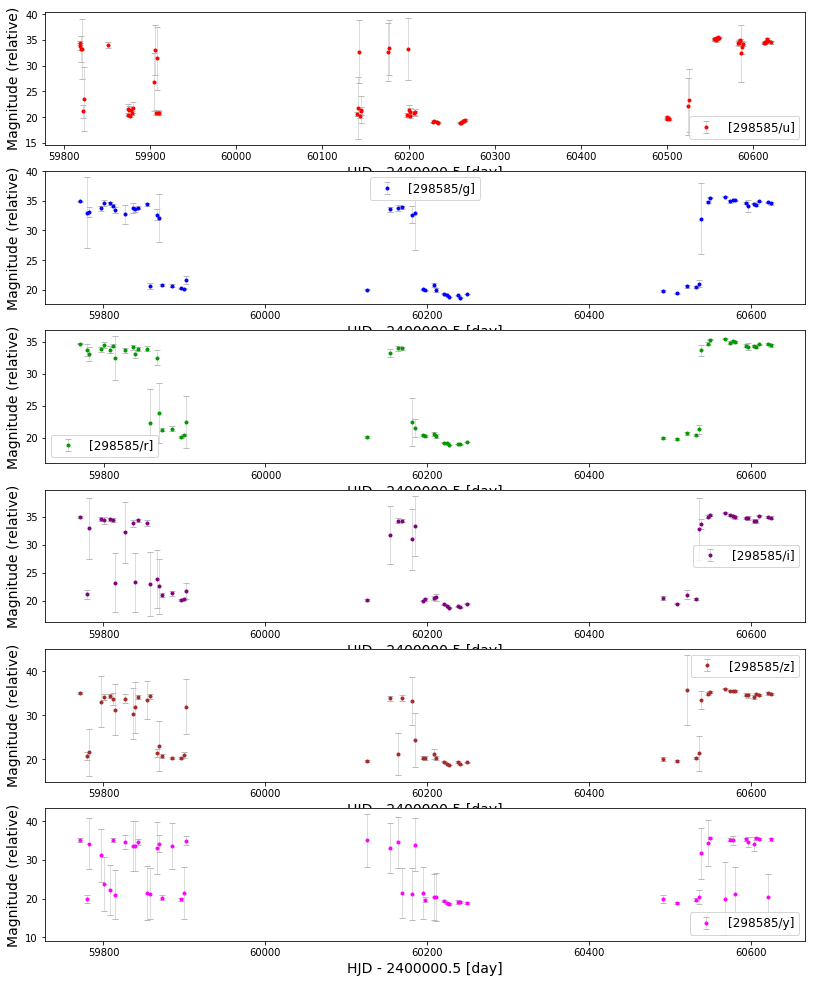

In [6]:
pycs.gen.mrg.colourise(lcs)

# This is ridiculous I know, don't ask.
setlist = [[[lc]] for lc in lcs]

pycs.gen.lc.multidisplay(setlist=setlist)

In [13]:
# Now, let's turn to mass production of plots...
from matplotlib.backends.backend_pdf import PdfPages



with PdfPages('10pc.pdf') as pdf:
	for tid in targets[:]:
		for oind in np.arange(10):
			lcs = load_curves(target_id=tid)
			fig = plt.figure(figsize=(8, 0.7))
			plt.suptitle("target_id = %i | obj %i" % (tid, oind), fontsize=30, y=0.6)
			pdf.savefig(fig)
			
			pycs.gen.mrg.colourise(lcs)
			for lc in lcs:
				fig = plt.figure(figsize=(8, 1.75))
				ax = plt.subplot(111)
				pycs.gen.lc.display([lc], ax=ax)
				ax.set_xlabel("")
				ax.set_ylabel("")
				plt.tight_layout()
				pdf.savefig(fig)	
				plt.close()